In [17]:
"""
Выберите ряд и постройте его модель ARIMA/GARCH.
Не обязательное дз. Попробуйте спрогнозировать график классическим ML
"""

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [18]:
# Инициализируем датасет 
sales_of_company_jan = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
sales_of_company_jan.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


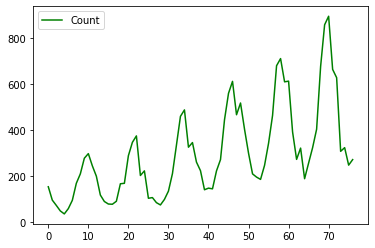

In [19]:
sales_of_company_jan.plot(color='green')
plt.show()

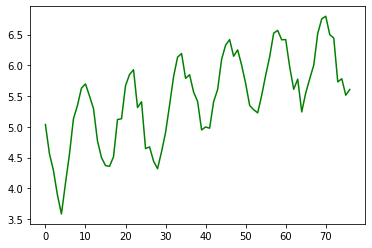

In [21]:
# Судя по изображению ряда, он не является стационарным: возрастает дисперсия, увеличивается мат.ожидание .
# Для начала нормализуем дисперсию. С этой целью применим метод Бокса-Кокса. 
# Метод boxcox возвращает набор данных, обработанный степенным преобразованием Бокса-Кокса

series = boxcox(sales_of_company_jan['Count'], 0)
plt.plot(series, color='green')
plt.show()
# with plt.style.context('bmh'):
#         plt.figure(figsize=(8, 4))
#         plt.plot(series, color='green')

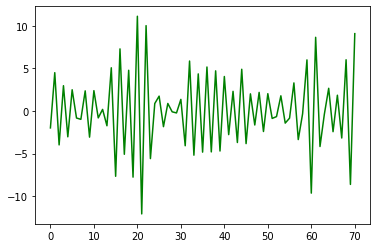

In [37]:
# Продолжим делать ряд стационарным. Попробовав нормализовать дисперсию, произведем дифференцирование ряда, 
# чтобы уравновесть математическое ожидание 
series = np.diff(series, 2)
plt.plot(series, color='green')
plt.show()

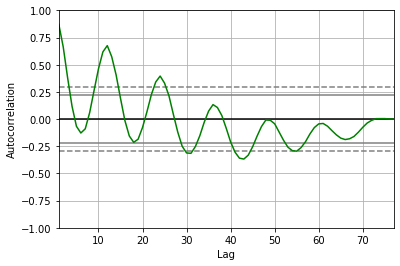

In [38]:
# рассмотрим график автокорреляции временного ряда. 
# Здесь мы видим автокорреляцию для большого числа лагов во временном ряду
autocorrelation_plot(sales_of_company_jan['Count'], color='green')

# Можем видеть, что существует положительная корреляция с первыми 3 лагами, 
# затем она попеременно переходит в отрицательную область и затухает.
# Автокрреляция, возможно, значима для первых 2 лагов.
# Отправную точку для параметра AR примем 2.

In [ ]:
# Из теории:
# ARIMA (p, d, q), где 

# p: число наблюдений отставания, включенных в модель, также называемое порядком отставания.
# d: количество раз, когда исходные наблюдения различаются, также называется степенью различия.
# q: размер окна скользящей средней, также называемый порядком скользящей средней
    
# ACF поможет нам определить q, 
# т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
# PACF поможет нам определить p, 
# т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

In [ ]:
# Напишем функцию теста на стационарност ряда Дики-Фуллера
def test_stationarity(timeseries):
    """
    Тест Дики-Фуллера может использоваться для проверки единичного корня 
    в одномерном процессе при наличии последовательной корреляции
    """
    print('Результат теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC') # передаем массив данных для тестирования
                                                 # maxlag: Максимальная задержка, включенная в тест, 
                                                      # по умолчанию 12*(nobs/100)^{1/4}
                                                 # регрессия {"c", "ct", "ctt", "nc"}
                                                      # «C»: только константа (по умолчанию).
                                                      # «Ct»: константа и тренд.
                                                      # «Ctt»: постоянный, линейный и квадратичный тренд.
                                                      # «Nc»: нет константы, нет тенденции
                                                 # autolag {«AIC», «BIC», «t-stat», None}
                                                      # Метод, используемый при автоматическом определении длины лага 
                                                      # среди значений 0, 1,…, maxlag
                                                 # store: Если True, то экземпляр результата возвращается 
                                                      # дополнительно к статистике adf
                                                    # regresults: Если True, возвращаются полные результаты регрессии
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Результат теста Дики-Фуллера:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\zlatt\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


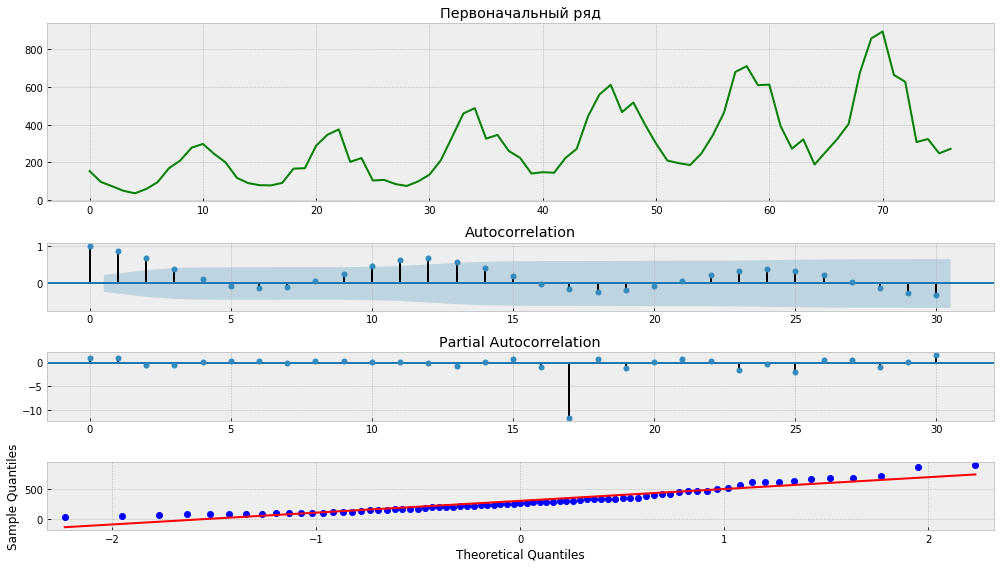

In [47]:
# Теперь, как и хотели одну ячейку назад, строим графики автокорреляции и частичной автокорреляции
# Для этого объявим следующую функцию

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='green', label='Or')
        ts_ax.set_title('Первоначальный ряд')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return
tsplot(sales_of_company_jan['Count'], lags=30)

In [48]:
# Мы прогоним модель ARIMA ко всему набору данных  
# и рассмотрим остаточные ошибки
# выберем метод модели ARIMA (1,1,0). Это устанавливает 
# значение задержки равным p=1 для авторегрессии, 
# (по графику PASF видно, что есть только 1 лаг, сильно отличный от нуля), 
# использует порядок разности d= 1, чтобы сделать временной ряд стационарным
# и использует модель скользящего среднего q=0 (на графие ACF значения функций после лага 0 резко падают).

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(sales_of_company_jan['Count'], order=(1,1,0))  # p, d, q
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Observations - Наблюдения
# Likelihood - Вероятность
# Imaginary - Воображаемый
# Modulus - Модуль

                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                   76
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -453.557
Method:                       css-mle   S.D. of innovations             94.470
Date:                Thu, 22 Jul 2021   AIC                            913.113
Time:                        22:07:28   BIC                            920.105
Sample:                             1   HQIC                           915.908
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.3424     15.454      0.087      0.931     -28.948      31.633
ar.L1.D.Count     0.3028      0.109      2.787      0.005       0.090       0.516
                                    Root

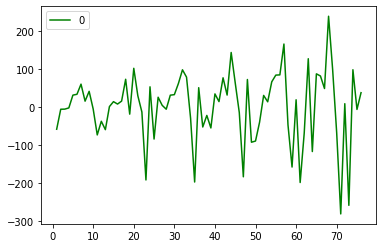

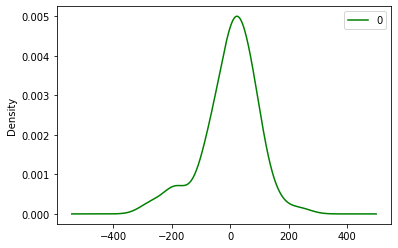

                0
count   76.000000
mean     0.479928
std     92.493985
min   -281.467970
25%    -41.823336
50%     14.064391
75%     60.508664
max    238.776703


In [40]:
# построим график остаточных ошибок
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)   # residual - остаточный 
residuals.plot(color='green')            # получаем линейный график остаточных ошибок, 
                                         # предполагая, что все еще может быть 
                                         # некоторая информация о тренде, не уловленная моделью
plt.show()
residuals.plot(kind='kde', color='green')   # 'kde' - график оценки плотности ядра, используя гауссовские ядра; если конкретно:
                                            # здесь - график плотности значений остаточных ошибок, 
                                            # предполагая, что ошибки являются гауссовыми, 
                                            # но могут не центрироваться на нуле
plt.show()
print(residuals.describe())

# Распределение остаточных ошибок отображается. 
# Результаты показывают, что в прогнозе действительно есть смещение (ненулевое среднее в невязках)

In [45]:
# Теперь произведем те же вычисления для нормализованного ряда и сравним результаты 
# Для упрощения сейчас не будем выводить отдельно графики корреляции и частичной автокорреляции,
# приняв те же значения параметров 
# Вначале проведем тест Дики-Фуллера, чтобы понять, является ли ряд стационарным


test_stationarity(series)
# Получаем статистику, равную -4.05. Согласно таблице, приведенной ниже, при выборке от 50 до 100
# (в нашем случае 76 наблюдений), всё, что левее значения -2.60, относится к стационарным рядам.
# Можно сделать вывод, что наш ряд является стационарным. 

Результат теста Дики-Фуллера:
Test Statistic                 -4.053829
p-value                         0.001153
#Lags Used                     12.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


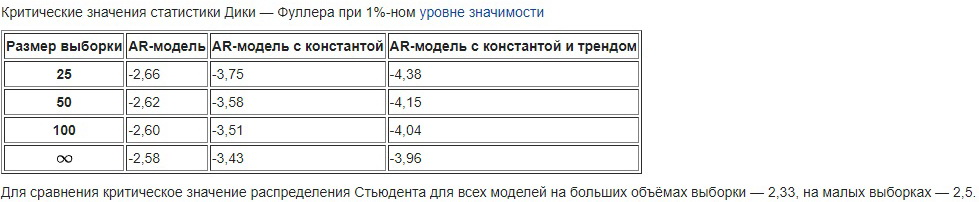

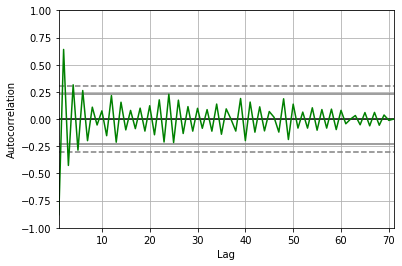

In [44]:
# Рассмотрим график автокорреляции временного ряда. 

autocorrelation_plot(series, color='green')
# Теперь можем видеть, что положительная корреляция сохраняется на протяжении ряда, хотя также затухает.
# Как и прежде, она попеременно переходит в отрицательную область.
# Автокрреляция, возможно, значима для первых 2 лагов.
# Отправную точку для параметра AR примем 2.

In [49]:
# Теперь построим модель ARIMA: выберем метод модели ARIMA (1,1,0)
model_2 = ARIMA(series, order=(1,1,0))
model_fit_2 = model_2.fit(disp=0)
print(model_fit_2.summary())
# Показатели изменились, в частности, замеров за счет смещения при нормализации стало 70 вместо 76
# Log Likelihood снизилась с -453.557 до -190.102

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   70
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -190.102
Method:                       css-mle   S.D. of innovations              3.606
Date:                Thu, 22 Jul 2021   AIC                            386.205
Time:                        22:17:35   BIC                            392.950
Sample:                             1   HQIC                           388.884
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      0.225     -0.038      0.970      -0.449       0.432
ar.L1.D.y     -0.9300      0.044    -21.017      0.000      -1.017      -0.843
                                    Roots           

predicted=4.329662, expected=2.012294
predicted=-3.534560, expected=-1.644277
predicted=1.723656, expected=2.182701
predicted=-1.422643, expected=-2.409360
predicted=1.827644, expected=2.032251
predicted=-2.169698, expected=-0.874405
predicted=1.816359, expected=-0.657765
predicted=-0.931935, expected=1.782499
predicted=-0.512953, expected=-1.422884
predicted=1.531055, expected=-0.840677
predicted=-1.464035, expected=3.295610
predicted=-0.548601, expected=-3.356708
predicted=2.806165, expected=-0.327329
predicted=-3.240628, expected=5.999628
predicted=0.229373, expected=-9.645668
predicted=4.827138, expected=8.650859
predicted=-8.626133, expected=-4.172819
predicted=7.761119, expected=-0.384860
predicted=-3.933331, expected=2.664414
predicted=-0.091840, expected=-2.431186
predicted=2.154998, expected=1.850444
predicted=-2.067931, expected=-3.172935
predicted=1.330824, expected=6.015007
predicted=-2.342198, expected=-8.622445
predicted=4.773554, expected=9.079620
Test MSE: 19.444


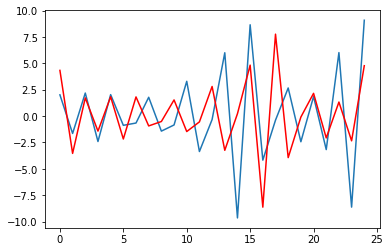

In [55]:
# На основе модели ARIMA попробуем получить прогностические значения 

X = series
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model_arima = ARIMA(history, order=(1,1,0))
    model_fit_3 = model_arima.fit(disp=0)
    output = model_fit_3.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


In [ ]:
# Выполнение примера выводит прогноз и ожидаемое значение для каждой итерации.
# Мы также можем рассчитать окончательный среднеквадратичный показатель ошибки (MSE) для прогнозов
# Создается линейный график, показывающий ожидаемые значения (синим цветом) по сравнению с прогнозами (красным)
# Модель может использовать дальнейшую настройку параметров p, d и q

# Обобщенная информация по методам:
# https://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/